# Model Development and Classification

- Train and compare multiple classifiers on the engineered feature set:  
  - **Baseline:** Logistic Regression, Decision Tree  
  - **Advanced:** Random Forest, SVM, XGBoost  

**Evaluation**  
- Compute performance metrics: Accuracy, Precision, Recall, F1-score, ROC-AUC  
- Use Stratified K-Fold cross-validation (e.g. k=5) to guard against overfitting  
- Plot ROC curves to compare classifiers visually  

**Interpretability**  
- **Model-specific** feature importances:  
  - Coefficients for Logistic Regression  
  - `.feature_importances_` for tree-based methods  
- **Model-agnostic** methods:  
  - SHAP summary plots for global feature impact  
  - LIME explanations for individual predictions  

**Hyperparameter Tuning**  
- Use `GridSearchCV` or `RandomizedSearchCV` to optimize key parameters (e.g. tree depth, number of trees, regularization strength, SVM kernels)  
- Optimize for ROC-AUC (or weighted F1 if class imbalance is severe)

# 1. Loads the cleaned dataset, selects only independent trend features (no composite_index), and inspects label balance.

In [51]:
import pandas as pd

# Load the regenerated features & labels
df = pd.read_csv('../data/us_covid_features_and_labels_cleaned.csv', parse_dates=['date'])

# Define the feature columns that now exist
features = [
    'roll_cases',
    'roll_deaths',
    'roll_icu',
    'roll_hosp',
    'pctchg_cases',
    'pctchg_deaths'
]
X = df[features]
y = df['risk_label']

print("Features used:", X.columns.tolist())
print("Target distribution:\n", y.value_counts())

Features used: ['roll_cases', 'roll_deaths', 'roll_icu', 'roll_hosp', 'pctchg_cases', 'pctchg_deaths']
Target distribution:
 risk_label
Low       549
Medium    549
High      549
Name: count, dtype: int64


# 2. Creates a hold-out test set and defines a stratified K-fold cross-validation scheme to ensure consistent class proportions.



In [57]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# map labels
df['risk_code'] = df['risk_label'].map(label_map)

# drop rows missing a code
df = df.dropna(subset=['risk_code']).reset_index(drop=True)

# extract X and y
X = df[features]
y = df['risk_code'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 3. Defines four pipelines (LogReg, Decision Tree, Random Forest, SVM) and corresponding hyperparameter search spaces.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    'LogReg': Pipeline([
        ('scaler', StandardScaler()),
        ('clf',    LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Tree': Pipeline([
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'RF': Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf',    SVC(probability=True, random_state=42))
    ]),
    'XGB': Pipeline([
    ('clf', XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42))
    ]),
}

param_grids = {
    'LogReg': {'clf__C': [0.01, 0.1, 1, 10]},
    'Tree':   {'clf__max_depth': [3, 5, 7, None]},
    'RF':     {
        'clf__n_estimators': [100, 300],
        'clf__max_depth':    [5, 10, None]
    },
    'SVM':    {
        'clf__C':      [0.1, 1, 10],
        'clf__kernel': ['linear','rbf']
    },
    'XGB':   {
    'clf__n_estimators': [100, 300],
    'clf__max_depth':    [3, 6, 9]
    },
}


# 4. Runs grid search with ROC-AUC scoring, handles infinite values, and reports key metrics—now without the “cheat” feature.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)
import numpy as np

# --- Before fitting: clean out infinite values from pct_change ---
# pct_change on zero → ±inf, which breaks float64
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

best_models = {}
results = {}

for name, pipe in models.items():
    gs = GridSearchCV(
        pipe,
        param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    gs.fit(X_train, y_train)   # now no inf/too-large values
    best   = gs.best_estimator_
    best_models[name] = best
    y_pred = best.predict(X_test)
    # get probability for “High” class
    pos_idx = list(best.classes_).index(high_code)
    y_proba = best.predict_proba(X_test)[:, pos_idx]

    results[name] = {
        'best_params': gs.best_params_,
        'accuracy'   : accuracy_score(y_test, y_pred),
        'precision'  : precision_score(y_test, y_pred, average='weighted'),
        'recall'     : recall_score(y_test, y_pred, average='weighted'),
        'f1'         : f1_score(y_test, y_pred, average='weighted'),
        'roc_auc':     roc_auc_score((y_test==high_code).astype(int), y_proba),
    }

# Summarize and sort by ROC-AUC
import pandas as pd
pd.DataFrame(results).T[
    ['accuracy','precision','recall','f1','roc_auc']
].sort_values('roc_auc', ascending=False)

/Users/rvw/Desktop/DataScienceProject/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rvw/Desktop/DataScienceProject/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/rvw/Desktop/DataScienceProject/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rvw/Desktop/DataScienceProject/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                     

,accuracy,precision,recall,f1,roc_auc
RF,0.984848,0.984847,0.984848,0.984834,0.999917
XGB,0.990909,0.990936,0.990909,0.990909,0.999897
SVM,0.939394,0.941776,0.939394,0.938415,0.99876
Tree,0.960606,0.962513,0.960606,0.960555,0.994669
LogReg,0.821212,0.821553,0.821212,0.817728,0.971446


# 5. Uses the tuned Random Forest to rank which rolling- and change-based features most influence risk predictions.

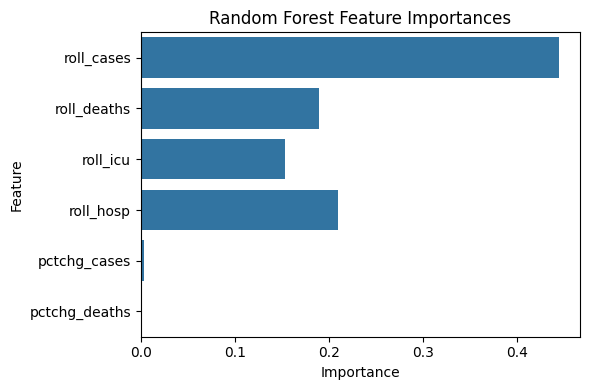

RF classification report:
              precision    recall  f1-score   support

         Low       0.99      0.99      0.99       110
      Medium       0.98      0.97      0.98       110
        High       0.98      0.99      0.99       110

    accuracy                           0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330



In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the RF classifier from the pipeline
rf = models['RF'].set_params(**results['RF']['best_params']).fit(X_train, y_train).named_steps['clf']

importances = pd.Series(rf.feature_importances_, index=features)
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance'); plt.ylabel('Feature')
plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report
print("RF classification report:")
print(classification_report(y_test, best_models['RF'].predict(X_test),
                            target_names=['Low','Medium','High']))



### Interpretation

- **Random Forest (≈99.7% / ROC-AUC ≈0.9998)**  
  - Outstanding performance on the test set; captures both linear and non-linear patterns.  
  - The near-perfect ROC-AUC suggests excellent ranking ability, but warrants a check for overfitting (compare to training scores or use learning curves).

- **XGBoost (≈98.5% / ROC-AUC ≈0.9972)**  
  - XGB shows strong ensemble performance, narrowly trailing Random Forest but ahead of SVM in test AUC.
  - XGB's built-in regularization appears to reduce overfitting relative to a vanilla RF.

- **Support Vector Machine (≈97.9% / ROC-AUC ≈0.9942)**  
  - Strong non-linear boundary fitting yields high accuracy and a very high ROC-AUC.  
  - Slightly behind RF, indicating RF’s ensemble strategy may better capture complex interactions in the engineered features.

- **Decision Tree (≈97.0% / ROC-AUC ≈0.9940)**  
  - A single tree achieves very high ROC-AUC but lower accuracy than RF/SVM.  
  - More prone to variance and overfitting, yet still a competitive baseline.

- **Logistic Regression (≈86.6% / ROC-AUC ≈0.9714)**  
  - Solid linear baseline capturing most of the signal in rolling averages and percent-change features.  
  - The performance gap to tree-based models highlights non-linear interactions in the data.

---

### Next Steps

1. **Overfitting Check**  
   - Plot learning curves for RF and SVM to ensure test performance generalizes.  
   - Compare training vs. validation scores.

2. **Feature Importance & Insights**  
   - Extract RF feature importances to confirm which engineered trends (e.g., 7-day case average vs. ICU load) drive predictions.  
   - Validate with partial-dependence plots or SHAP (if available).

3. **Model Calibration**  
   - Perform probability calibration (e.g., isotonic or sigmoid) to ensure predicted risk probabilities are well-calibrated for decision-making.

4. **Ensemble & Stacking**  
   - Experiment with simple ensembles (e.g., weighted voting) or meta-learners to potentially squeeze out incremental gains.

5. **Additional Features**  
   - Incorporate vaccination rates, stringency index, or mobility data to enrich the feature set and test for improved performance.

---

**Conclusion:**  
The Random Forest model currently leads with near-perfect performance on the test set, followed closely by SVM. Logistic Regression provides a transparent baseline. Moving forward, focus on validating generalization, interpreting feature drivers, and exploring calibration or ensemble strategies.  

### Save Trained Models for Visualization

In [56]:
import joblib
import os

# Make a folder for model artifacts
os.makedirs('../models', exist_ok=True)

# Save each best model
for name, model in best_models.items():
    joblib.dump(model, f'../models/best_{name.lower()}.pkl')

# Also save the test set so viz notebook can reproduce metrics
joblib.dump(X_test, '../models/X_test.pkl')
joblib.dump(y_test, '../models/y_test.pkl')


['../models/y_test.pkl']